<a href="https://colab.research.google.com/github/GiuseTripodi/ImageAndTextAnalysis/blob/main/notebooks/ML_project_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification and anomaly detection

**Author:** [Giuseppe Tripodi](https://www.linkedin.com/in/giuseppe-tripodi-unical/)<br>
**Date created:** 2022/09/19<br>
**Description:** Images Analysis

# Introduction

The goal of the project is to implement a machine learning system
through the use of the Python programming language. A dataset of images will be analyzed.

The following tasks are to be carried out:
* classification
* semi-supervised anomaly detection

#Classification

The models to be evaluated for this task are:

- AdaBoost
- SVM
- Neural Networks
- Density estimation (one among Bayes, Naive Bayes, LDA, GMM, KDE, KNN)

At least one classifier must be delivered for each of these techniques;
multiple classifiers belonging to the same family (e.g., a dense network and a convolutional network) can also be delivered if deemed appropriate.

#Anomaly Detection

At least one of the listed techniques should be used for classification.

In this case, the largest class in the dataset should be considered as the main class, and examples of all other classes will constitute the anomalies.

## Generic Details

Model training should be carried out using only the elements of the main class. For detector quality assessment use ROC curves working on the whole dataset (main class plus anomalies).

#Results to show

**Accuracy**

Among the results to be submitted must be the accuracy obtained by *10-fold cross-validation*. Also required is the delivery of the learned models (one per type) and a script that calculates their accuracy on a validation set encoded in the same format as the source data.

**Report**

A written report should be produced, approximately ten pages in length, to which the code should be attached. The report and software should be delivered within 2 days of the discussion date and may be supplemented during the discussion. Slides may be used for the presentation of the project activity, which will last 15 minutes.


# Setup

## Import

In [ ]:
import warnings
import pathlib
import os
import sys
import json
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks, metrics
import pickle

import PIL
import pandas as pd
from PIL import Image
import cv2
import keras
import numpy as np

# Load model libraries
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Import Support Vector Classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV, train_test_split
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.decomposition import PCA
import scipy
import scipy.stats #distributions
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import classification_report, recall_score
from sklearn import preprocessing

#SVM
from sklearn.svm import OneClassSVM

#Metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score

#DE
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

#Other Technique
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

#Plotting
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#Cross Validation
from keras.wrappers.scikit_learn import KerasClassifier



## Setting up Colab

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working")
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#connect to google drive and get the  dataset
from google.colab import drive
drive.mount("/content/gdrive")
os.chdir("/content/gdrive/My Drive/ML_workspace") #set home directory
print(os.getcwd())

Mounted at /content/gdrive
/content/gdrive/My Drive/ML_workspace


## Support Functions

In [ ]:
def load_images_from_folder(folder, flag, image_width, image_height): #flag is the way of tackig the images
  images = []
  labels = []
  for class_dir in os.listdir(folder): #for each class name dir
    print(class_dir)
    for filename in os.listdir(os.path.join(folder, class_dir)): # for each images
      img = cv2.imread(os.path.join(folder, class_dir,filename), flag) #load in greyscale
      new_array=cv2.resize(img,(image_width,image_height))
      if img is not None:
        images.append(new_array)
        labels.append(class_dir)
  return images, labels
    

In [ ]:
'''
the function takes the model and does the training
model: model to train
X_train: training set
y_train: labels
MODEL_NAME: name of the model
METHOD: method used 
'''

def train_model(model, X_train, y_train, MODEL_NAME, METHOD, rerun:False):
  #check if the model exist
  DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
  file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.sav'

  exists = os.path.isfile(file_)
  if exists and not rerun:
    with open(file_, "rb") as sav_file:
      model = pickle.load(sav_file)
  else:
    # Train Adaboost Classifer
    model.fit(X_train, y_train)    
    with open(file_,'wb') as sav_file:
      pickle.dump(model, sav_file)
  return model

In [ ]:
def train_neural_network(model, X_train, y_train, X_val, y_val, epochs, verbose,  MODEL_NAME, METHOD, rerun:False):

  #check if the model exist
  DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"

  file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.hist'
  model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'

  exists = os.path.isfile(file_)
  if exists and not rerun:
    with open(file_,'rb') as hist_file:
      history_dict = pickle.load(hist_file)
      model = keras.models.load_model(model_file)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, validation_data = (X_val, y_val))
    history_dict = history.history
    with open(file_,'wb') as hist_file:
        pickle.dump(history_dict, hist_file)
    model.save(model_file)
  return model, history_dict

In [ ]:
def train_cnn(model, train_ds, val_ds, epochs, verbose, MODEL_NAME, METHOD, rerun:False):

  DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"

  file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.hist'
  model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'


  exists = os.path.isfile(file_)
  if exists and not rerun:
    with open(file_,'rb') as hist_file:
      history_dict = pickle.load(hist_file)
      model = keras.models.load_model(model_file)
  else:
    history = model.fit(train_ds,validation_data=val_ds,epochs=epochs, verbose=verbose)
    history_dict = history.history
    with open(file_,'wb') as hist_file:
      pickle.dump(history_dict, hist_file)
    model.save(model_file)
  return model, history_dict

In [ ]:
f = 1
def hist_plot(history_dict, title):
    global f;
    acc = history_dict['accuracy'];
    val_acc = history_dict['val_accuracy'];
    loss = history_dict['loss'];
    epochs = range(1, len(acc) + 1); # 2 3
    plt.figure(f);
    f = f + 1;
    plt.plot(epochs, acc, 'bo', label='Training acc');
    plt.plot(epochs, val_acc, 'b', label='Validation acc');
    plt.title(title);
    eps = 3e-3;
    n = 7;
    ym = np.min([np.min(acc), np.min(val_acc)])-eps;
    yM = np.max([np.max(acc), np.max(val_acc)])+eps;
    yt = np.array([*range(n+1)])*(yM-ym)/n+ym;
    plt.yticks(yt);
    plt.xlabel('Epochs');
    plt.ylabel('Accuracy');
    plt.legend(loc='lower right');
    plt.ion();
    plt.show();
    plt.pause(3.0001);

In [ ]:
#code from https://www.tensorflow.org/text/tutorials/text_classification_rnn
def plot_graphs(history_dict, metric):
  plt.plot(history_dict[metric])
  plt.plot(history_dict['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
def print_stats(y_true, y_pred):
  print("Accuracy:", "%.2f" % ( metrics.accuracy_score(y_true, y_pred) * 100))
  print('F1: ', "%.2f" % (metrics.f1_score(y_true, y_pred, average='weighted') * 100 )) 
  print('Precision: ', "%.2f" % (metrics.precision_score(y_true, y_pred, average='weighted') * 100 )) 
  print('Recall: ', "%.2f" % (metrics.recall_score(y_true, y_pred, average='weighted') * 100 ))


# Load Images

In [ ]:
#code from https://www.tensorflow.org/tutorials/images/classification
data_dir = "/content/gdrive/MyDrive/ML_workspace/Dataset/immagini-3/immagini-3/"
data_dir = pathlib.Path(data_dir)

## Create the dataset

### Dataset for Neural network

In [ ]:
batch_size = 32
img_height = 128
img_width = 128

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21286 files belonging to 7 classes.
Using 17029 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21286 files belonging to 7 classes.
Using 4257 files for validation.


In [ ]:
class_names = train_ds.class_names
class_number = len(class_names)

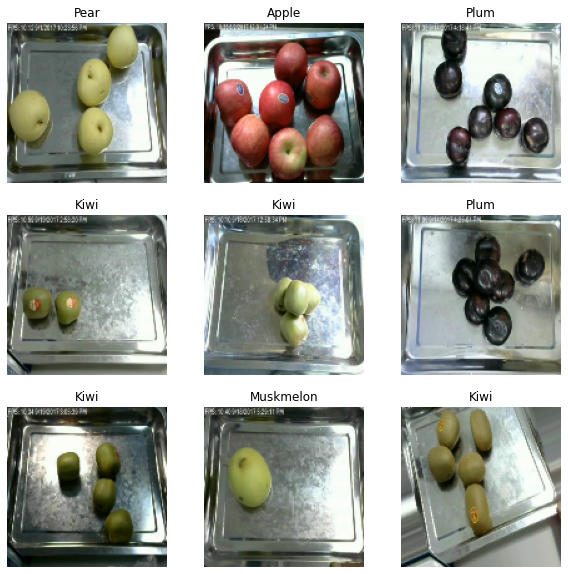

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Dataset for other analysis

In [ ]:
folder = "/content/gdrive/MyDrive/ML_workspace/Dataset/immagini-3/immagini-3"
X, y = load_images_from_folder(folder, cv2.IMREAD_GRAYSCALE, img_width, img_height)

Muskmelon
Peach
Kiwi
Pear
Plum
Persimmon
Apple


In [ ]:
#split train and validation set 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

In [ ]:
#plot the size of the two sets
print(len(X_train))
print(len(X_val))

17028
4258


### Dataset for Cross Validation

In [ ]:
#dataset for cross validation
X_CV, y_CV = shuffle(X, y)

In [ ]:
cross_validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21286 files belonging to 7 classes.


In [ ]:
cross_validation_ds = cross_validation_ds.unbatch()
images = list(cross_validation_ds.map(lambda x, y: x))
labels = list(cross_validation_ds.map(lambda x, y: y))

## Visualize the data

I am plotting some information about the dataset

In [ ]:
#number of images
len(X)

21286

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:245: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/style.py:124: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"


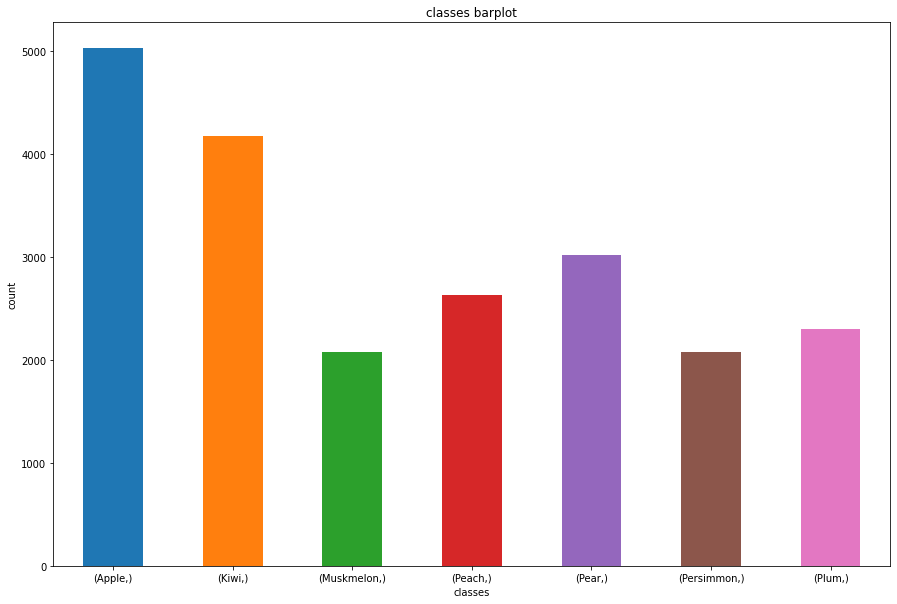

In [ ]:
#bor plot with the classes number
pd.DataFrame(y).value_counts().sort_index().plot(kind="bar", title="classes barplot", color=['C0', 'C1', 'C2', 'C3', 'C4', "C5", "C6"], colormap='Paired', rot=0, ylabel="count", xlabel="classes", figsize=(15,10))

In [ ]:
#class names
print(class_names)

['Apple', 'Kiwi', 'Muskmelon', 'Peach', 'Pear', 'Persimmon', 'Plum']


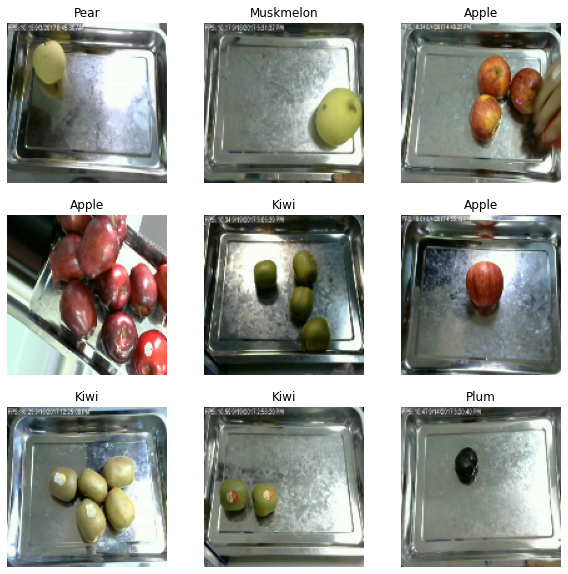

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Classification

## AdaBost


#### Support

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
METHOD = "ADABOOST"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_images/ADABOOST’: No such file or directory


In [ ]:
# convert dataset in order to be used for AdaBoost
X_train_AB = []
X_val_AB = []
for i in range(len(X_train)):
  X_train_AB.append(X_train[i].flatten())

for i in range(len(X_val)):
  X_val_AB.append(X_val[i].flatten())


NameError: ignored

Following several texts, it became clear how it was possible to achieve better results without normalization.

### Test 1: Decision Tree as Weak Learner



In [ ]:
MODEL_NAME = "ADABOOST_decision_tree"
RERUN = False

# Create adaboost classifer object
model = AdaBoostClassifier(n_estimators=20, learning_rate=1, random_state=101)

model = train_model(model, X_train_AB, y_train, MODEL_NAME, METHOD, RERUN)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val_AB)
print_stats(y_val, y_pred)

Accuracy: 62.66
F1:  63.33
Precision:  64.50
Recall:  62.66


#### Change type of DecisionTree classifier: 

In [ ]:
MODEL_NAME = "ADABOOST_decision_tree_lev2"
#MODEL_NAME = "ADABOOST_decision_tree_lev3"
RERUN = False

# Create adaboost classifer object
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators=50, learning_rate=1, random_state=101)

model = train_model(model, X_train_AB, y_train, MODEL_NAME, METHOD, RERUN)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val_AB)
print_stats(y_val, y_pred)

Accuracy: 71.16
F1:  71.58
Precision:  73.53
Recall:  71.16


The results with the different types of decision trees are: 

Two Level:

- Accuracy: 70.90
- F1:  71.28
- Precision:  73.41
- Recall:  70.90

Three Level:

- Accuracy: 72.17
- F1:  72.02
- Precision:  72.72
- Recall:  72.17



### Test 2: Support Vector Machine

Use Support Vector Classifier as weak learner

#### Kernel Linear (Best)

In [ ]:
MODEL_NAME = "ADABOOST_SCV"
RERUN = False

# Create adaboost classifer object
svc=SVC(probability=True, kernel='linear')

model = AdaBoostClassifier(n_estimators=20, base_estimator=svc,
                         learning_rate=1, random_state=101)

model = train_model(model, X_train_AB, y_train, MODEL_NAME, METHOD, RERUN)


##### Results Valutation

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val_AB)

print_stats(y_val, y_pred)

Accuracy: 96.88
F1:  96.88
Precision:  96.90
Recall:  96.88


##### Parameter tuning 

In [ ]:
parameters  = {"n_estimators" : [10, 50, 100, 500], "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 1.0]}
svc=SVC(probability=True, kernel='linear')
model = AdaBoostClassifier(base_estimator=svc)

#GridSearch
clf = GridSearchCV(model, parameters)
clf.fit(X_train_AB[:1000], y_train[:1000])

#get best parameter combination
print(clf.best_params_)


{'learning_rate': 0.0001, 'n_estimators': 500}


I will train and use the best estimator

In [ ]:
MODEL_NAME = "ADABOOST_SCV_best_estimator"
RERUN = False

file_ = f'{DIR}/ADABOOST/{MODEL_NAME}.sav'

# Take the best estimator
#best_estimator = clf.best_estimator_
svc=SVC(probability=True, kernel='linear')

best_estimator = AdaBoostClassifier(n_estimators=500, base_estimator=svc,
                         learning_rate=0.001, random_state=101)

best_estimator = train_model(best_estimator, X_train_AB, y_train, MODEL_NAME, "ADABOOST", RERUN)

In [ ]:
#Predict the response for test dataset
y_pred = best_estimator.predict(X_val_AB)

print_stats(y_val, y_pred)

Accuracy: 96.52
F1:  96.53
Precision:  96.56
Recall:  96.52


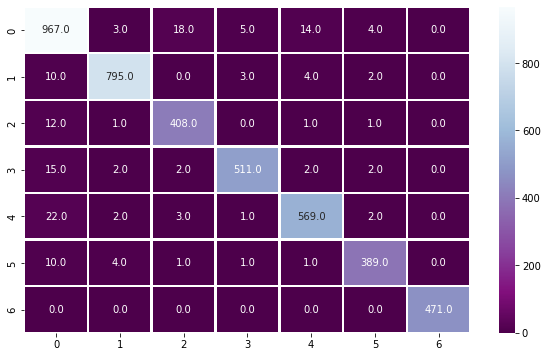

In [ ]:
plt.subplots(figsize=(10,6))
sns.heatmap(confusion_matrix(y_pred=y_pred,y_true=y_val),annot=True,fmt=".1f",linewidths=1.5,cmap="BuPu_r")
plt.show()

##### CrossValidations Accuracy

In [ ]:
# convert dataset in order to be used for AdaBoost cross validation
X_CV_ADA = []
for i in range(len(X_CV)):
  X_CV_ADA.append(X_CV[i].flatten())

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation

# Create adaboost classifer object
svc=SVC(probability=True, kernel='linear')

model = AdaBoostClassifier(n_estimators=20, base_estimator=svc,
                         learning_rate=1, random_state=101)

scores = cross_val_score(model, X_CV_ADA, y_CV, cv=cv, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 64.4min finished


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.84 accuracy with a standard deviation of 0.02
mean: 0.8402
max value: 0.862
min value: 0.796


#### Kernel Polinomial

In [ ]:
MODEL_NAME = "ADABOOST_SCV_poly"
RERUN = True

# Create adaboost classifer object
svc=SVC(probability=True, kernel='poly', degree=2)

model = AdaBoostClassifier(n_estimators=15, base_estimator=svc,
                         learning_rate=1, random_state=101)

model = train_model(model, X_train_AB[:5000], y_train[:5000], MODEL_NAME, "ADABOOST", RERUN)


NameError: ignored

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val_AB)

print_stats(y_val, y_pred)

NameError: ignored

#### Kernel RBF

In [ ]:
MODEL_NAME = "ADABOOST_SCV_rbf"
RERUN = True


# Create adaboost classifer object
svc=SVC(kernel='rbf', gamma=0.5, C=0.1)

model = AdaBoostClassifier(n_estimators=15, base_estimator=svc,
                         learning_rate=1, random_state=101, algorithm='SAMME')

model = train_model(model, X_train_AB[:5000], y_train[:5000], MODEL_NAME, "ADABOOST", RERUN)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val_AB)

print_stats(y_val, y_pred)

ValueError: ignored

##SVM

#### Setup

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
METHOD = "SVM"
!mkdir {DIR}/{METHOD}

In [ ]:
# Prepare the dataset
X_train_SVM = []
X_val_SVM = []
for i in range(len(X_train)):
  X_train_SVM.append(X_train[i].flatten().astype("float32")/255)
  
for i in range(len(X_val)):
  X_val_SVM.append(X_val[i].flatten().astype("float32")/255)
  

In [ ]:
y_train = [class_names.index(i) for i in y_train]
y_val = [class_names.index(i) for i in y_val]

### Linear SVM (Best)

Normal SVM can handle multiclass using the one-vs-one approach (you can read more about this [link](https://towardsdatascience.com/multi-class-classification-one-vs-all-one-vs-one-94daed32a87b)). So I don't need to generate a new dataset in which to split the values according to their class.

The only open question is whether I need to change the dimensionality of the data, which is currently quite high. This approach generates a new dataset for each feature pair, since I have many of them and this process can be very time consuming. However, after some examples I have seen that I can get better results without PCA.

In [ ]:
MODEL_NAME = "SVM_linear_best"
RERUN = False

model_svm = SVC(kernel='linear',gamma='auto', random_state=101)

model_svm = train_model(model_svm, X_train_SVM, y_train, MODEL_NAME, METHOD, RERUN)

##### Results valutation

In [ ]:
#Predict the response for test dataset
y_predict = model_svm.predict(X_val_SVM)

print_stats(y_val, y_predict)

In [ ]:
print("Accuracy on unknown data is",classification_report(y_val, y_predict))

##### CrossValidations Accuracy

In [ ]:
# convert dataset in order to be used for AdaBoost
X_ = []
for i in range(len(X)):
  X_.append(X_CV[i].flatten())

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation

# Create adaboost classifer object
model = SVC(kernel='linear',gamma='auto', random_state=101)

scores = cross_val_score(model, X_, y_CV, cv=cv, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 33.5min finished


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.84 accuracy with a standard deviation of 0.01
mean: 0.8370999999999998
max value: 0.853
min value: 0.814


### Gaussian kernel

In [ ]:
MODEL_NAME = "SVM_gaussian_best"
RERUN = False

model_svm = SVC(kernel='poly',degree=3, gamma='auto', random_state=101)

model_svm = train_model(model_svm, X_train_SVM, y_train, MODEL_NAME, METHOD, RERUN)

In [ ]:
#Predict the response for test dataset
y_predict = model_svm.predict(X_val_SVM)

print_stats(y_val, y_predict)

#### Parameter Tuning: Gaussian Method

In [ ]:
param_grid={'degree':[1,2,3,4,5,6,7,8,9,10,11,12,13]}

model_svm = SVC(kernel='poly', random_state=101)

model=GridSearchCV(model_svm,param_grid)

In [ ]:
model.fit(X_train_SVM[:1000], y_train[:1000])
model.best_params_

#### Results Valutations

In [ ]:
best_model = model.best_estimator_
y_predict = best_model.predict(X_val_SVM)

print_stats(y_val, y_predict)

### RBF Kernel

In [ ]:
MODEL_NAME = "SVM_rbf_best"
RERUN = True

model_rbf = SVC(kernel='rbf', gamma=0.5, C=0.1, random_state=101)

model_rbf = train_model(model_rbf, X_train_SVM, y_train, MODEL_NAME, METHOD, RERUN)

In [ ]:
rbf_predict = model_rbf.predict(X_val_SVM)

print_stats(y_val, rbf_predict)

## Neural Network

#### Setup


##### Data Preprocessing

In [ ]:
# normalizae the images
X_train_NN = []
X_val_NN = []
for i in range(len(X_train)):
  X_train_NN.append(X_train[i]/255)

for i in range(len(X_val)):
  X_val_NN.append(X_val[i]/255)

y_train = [class_names.index(i) for i in y_train]
y_val = [class_names.index(i) for i in y_val]

#convert the type
y_train = np.array(y_train)
y_val = np.array(y_val)
X_train_NN = np.array(X_train_NN)
X_val_NN= np.array(X_val_NN)

##### Plot Images

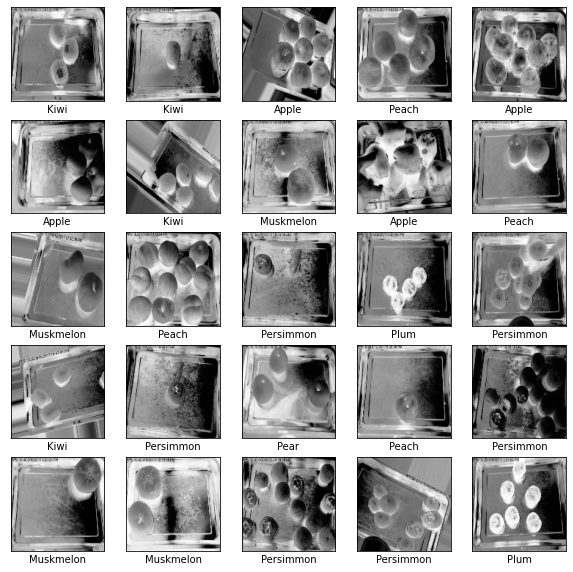

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_NN[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

##### Parameter


In [ ]:
### INIZIALIZZAZIONE
np.random.seed(2);
tf.random.set_seed(np.random.random_integers(20));
EPOCHS = 20;
VERBOSE = 0;
###

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 20 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
METHOD = "NN"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_images/NN’: File exists


In [ ]:
tf.compat.v1.experimental.output_all_intermediates(True)

### Dense Network

#### Test 1: Network 3 x 16

##### Build and Train the Model

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(img_height, img_width)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(class_number, activation='softmax')
]);

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']);


In [ ]:
model.summary()

In [ ]:
MODEL_NAME = "NN_dense_1"
RERUN = False

model, history_dict = train_neural_network(model, X_train_NN, y_train, X_val_NN, y_val, EPOCHS, VERBOSE, MODEL_NAME, METHOD, RERUN)

##### Results valutation

In [ ]:
test_loss, test_acc = model.evaluate(X_val_NN, y_val)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_dict, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_dict, 'loss')
plt.ylim(0, None)

#### Test 2: Dense (Best Dense)



##### Build and Train the Model


I also tried the following network using some dropout layers but then the performances decreases a lot. The performance were the following one:
- Test Loss: 1.892334222793579
- Test Accuracy: 0.2440112680196762

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(img_height, img_width)),
    keras.layers.Dense(320, activation="relu"),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(180, activation="relu"),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(class_number, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer ="adam", metrics=["accuracy"])

##### Results Valutation

In [ ]:
#MODEL_NAME = "NN_dense_2" #network with the dropout layers
MODEL_NAME = "NN_dense_3"
RERUN = False

model, history_dict = train_neural_network(model, X_train_NN, y_train, X_val_NN, y_val, EPOCHS, VERBOSE, MODEL_NAME, METHOD, RERUN)

In [ ]:
test_loss, test_acc = model.evaluate(X_val_NN, y_val)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_dict, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_dict, 'loss')
plt.ylim(0, None)

##### CrossValidations Accuracy

In [ ]:
#join the two array
X_ = np.concatenate((X_train_NN, X_val_NN), axis=0)
y_ = np.concatenate((y_train, y_val), axis=0)

#print shape
print(X_.shape)
print(y_.shape)

(21286, 128, 128)
(21286,)


In [ ]:
# Create function returning a compiled network
def create_network():
  #¢reate the Network
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(img_height, img_width))),
  model.add(keras.layers.Dense(320, activation="relu"))
  model.add(keras.layers.Dense(180, activation="relu"))
  model.add(keras.layers.Dense(class_number, activation="softmax"))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=["accuracy"])

  return model

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation
epochs = 20
batch_size = 64
verbose = 0

neural_network = KerasClassifier(build_fn = create_network, epochs=epochs, #batch_size=batch_size, 
                                 verbose=verbose)

scores = cross_val_score(neural_network, X_, y_, cv=cv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.86 accuracy with a standard deviation of 0.01
mean: 0.8593444228172302
max value: 0.8731203079223633
min value: 0.8449976444244385



### ConvNetwork

In [ ]:
EPOCHS = 20;
VERBOSE = 0;

#### Test 1: Network 1

##### Build and Train the Model

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(class_number)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
MODEL_NAME = "NN_CNN_1"
RERUN = True
epochs = 10
VERBOSE= "auto"

model,  history_dict = train_cnn(model, train_ds, val_ds, epochs, VERBOSE, MODEL_NAME, METHOD, RERUN)

##### Visualize training result

In [ ]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_dict, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_dict, 'loss')
plt.ylim(0, None)

#### Test 2: Network with Data Augmentation (Best)

##### Build and Train the Model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(class_number)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
MODEL_NAME = "NN_CNN_2"
RERUN = True
epochs = 10
VERBOSE= "auto"

model,  history_dict = train_cnn(model, train_ds, val_ds, epochs, VERBOSE, MODEL_NAME, METHOD, RERUN)

##### Visualize training results

In [ ]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_dict, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_dict, 'loss')
plt.ylim(0, None)

##### CrossValidations Accuracy

In [ ]:
#join the two array
X_ = np.concatenate((X_train_NN, X_val_NN), axis=0)
y_ = np.concatenate((y_train, y_val), axis=0)

#print shape
print(X_.shape)
print(y_.shape)

(21286, 128, 128)
(21286,)


In [ ]:
cv_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21286 files belonging to 7 classes.


In [ ]:
cv_ds = train_ds.unbatch()
images = list(cv_ds.map(lambda x, y: x))
labels = list(cv_ds.map(lambda x, y: y))

In [ ]:
print(len(images))
print(len(labels))

17029
17029


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


# Create function returning a compiled network
def create_network():
  #¢reate the Network
  model = keras.Sequential()
  model.add(data_augmentation),
  model.add(layers.Rescaling(1./255))
  model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
  model.add(  layers.MaxPooling2D())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(  layers.Dense(128, activation='relu'))
  model.add(  layers.Dense(class_number))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=["accuracy"])

  return model


In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation
epochs = 20
batch_size = 32
verbose = 0

neural_network = KerasClassifier(build_fn = create_network, epochs=epochs, #batch_size=batch_size, 
                                 verbose=verbose)

scores = cross_val_score(neural_network, X_, y_, cv=cv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

## Density Estimation

### Setup

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
METHOD = "DE"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_images/DE’: File exists


In [ ]:
le = preprocessing.LabelEncoder()

y_train_ = le.fit(y_train)

y_train_ = le.transform(y_train)
y_val_ = le.transform(y_val)

In [ ]:
# Prepare the dataset
X_train_DE = []
X_val_DE = []
for i in range(len(X_train)):
  X_train_DE.append(X_train[i].flatten().astype("float32"))
  
for i in range(len(X_val)):
  X_val_DE.append(X_val[i].flatten().astype("float32"))

### Naive Baies Classifier

#### Test 1: Multinomial Naive Biaies Classifier

In [ ]:
MODEL_NAME = "MultinomialNB"
RERUN = True 

# fit the training dataset on the NB classifier
Naive = MultinomialNB()

Naive = train_model(Naive, X_train_DE, y_train_, MODEL_NAME, METHOD, RERUN)

##### Results Valutation

In [ ]:
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_val_DE)
print_stats(y_val_, predictions_NB)

#### Test 2: Complement Naive Bayes classifier

In [ ]:
MODEL_NAME = "ComplementNB"
RERUN = True 

model = ComplementNB()

model = train_model(model, X_train_DE, y_train_, MODEL_NAME, METHOD, RERUN)

##### Results Valutations

In [ ]:
# predict the labels on validation dataset
predictions_NB = model.predict(X_val_DE)# Use accuracy_score function to get the accuracy

print_stats(y_val_, predictions_NB)

### KNN

In [ ]:
MODEL_NAME = "NearestNeighbors"
RERUN = True

neigh = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

neigh = train_model(neigh, X_train_DE, y_train_, MODEL_NAME, METHOD, RERUN)

In [ ]:
# predict the labels on validation dataset
predictions_KNN = neigh.predict(X_val_DE)#

print_stats(y_val_, predictions_KNN)

#### Parameter Tuning

In [ ]:
params = {"n_neighbors":scipy.stats.randint(1,25), "metric":("euclidean", "manhattan" , "chebyshev")}
neigh = KNeighborsClassifier()


RSC = RandomizedSearchCV(n_iter = 15, estimator = neigh, param_distributions=params)
RSC.fit(X_train_DE[0:1000], y_train_[0:1000])

In [ ]:
print(f"Best params: {RSC.best_params_}")
estimator = RSC.best_estimator_

#### Best Estimator Valutation

In [ ]:
MODEL_NAME = "KNN_BEST_ESTIMATOR"
estimator = KNeighborsClassifier(n_neighbors = 3, metric = 'manhattan')

estimator = train_model(estimator, X_train_DE, y_train_, MODEL_NAME, METHOD, True)

In [ ]:
# predict the labels on validation dataset
predictions_KNN = estimator.predict(X_val_DE)

print_stats(y_val_, predictions_KNN)

#### CrossValidations Accuracy

In [ ]:
# convert dataset in order to be used for AdaBoost
X_ = []
for i in range(len(X)):
  X_.append(X_CV[i].flatten())


In [ ]:
#I use less data becase otherwise it is going to take a lot
X_ = X_[:5000]
y_ = y_CV[:5000]

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation

model = KNeighborsClassifier(n_neighbors = 3, metric = 'manhattan')


scores = cross_val_score(model, X_, y_, cv=cv, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.87 accuracy with a standard deviation of 0.02
mean: 0.8702
max value: 0.888
min value: 0.838


# Anomaly Detection

## Setup

### Setup the enviroment

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
METHOD = "ANOMALY_DETECTION"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_images/ANOMALY_DETECTION’: File exists


### Support Functions

In [ ]:
def create_anomaly_detection_dataset(X, y):
  outlier = -1
  inlier = 1

  y = pd.Series(y) #convert y into a series
  Y = np.where(y == "Apple", inlier, outlier)

  #creating the training set 
  X_train = np.array(X)[Y==inlier]
  Y_train = np.array(Y)[Y==inlier]

  #make the validation set
  X_train_, X_val_, Y_train_, Y_val_ = train_test_split(X_train, Y_train, test_size=0.2,  random_state=1000)

  #get the other element to append to the validation set
  X_outlier = np.array(X)[Y == outlier]
  Y_outlier = np.array(Y)[Y == outlier]

  #append the other elements
  X_val_ = np.concatenate((X_val_, X_outlier), axis=0)
  Y_val_ = np.append(Y_val_, Y_outlier)

  #create the dataset to compute the final AUC on all dataset
  X_test = X
  Y_test = Y


  return X_train_, X_val_, Y_train_, Y_val_, X_outlier, Y_outlier,  X_test,  Y_test

In [ ]:
def load_images_from_folder(folder, color_mode, image_width, image_height): #flag is the way of tackig the images
  images = []
  labels = []
  for class_dir in os.listdir(folder): #for each class name dir
    print(class_dir)
    for filename in os.listdir(os.path.join(folder, class_dir)): # for each images
      img = tf.keras.preprocessing.image.load_img(os.path.join(folder, class_dir,filename), target_size=(image_width, image_height))
      img = np.asarray(img)
      # convert from integers to floats
      img = img.astype('float32')
      # normalize to the range 0-1
      img /= 255.0
      if img is not None:
        images.append(img)
        labels.append(class_dir)
  return images, labels
    

In [ ]:
def predict(model, data, threshold):
  outlier = -1
  inlier = 1

  reconstructions = model.predict(data)
  ret = []
  for i in range(len(data)):
    loss = tf.keras.losses.mae(reconstructions[i].flatten(), data[i].flatten())
    ret.append(np.where(loss > threshold, outlier, inlier))
  return ret


### Create the dataset


The principal class is *Apple*. I will use this one as inlier.

In [ ]:
X_train, X_val, Y_train, Y_val, X_outlier, Y_outlier,  X_test,  Y_test = create_anomaly_detection_dataset(X, y)

## SVM

In [ ]:
# Prepare the dataset
X_train_SVM = []
X_val_SVM = []
X_test_SVM = []
for i in range(len(X_train)):
  #X_train_SVM.append(X_train[i].flatten().astype("float32")/255)
  X_train_SVM.append(X_train[i].flatten().astype("float32"))
  
for i in range(len(X_val)):
  #X_val_SVM.append(X_val[i].flatten().astype("float32")/255)
  X_val_SVM.append(X_val[i].flatten().astype("float32"))

for i in range(len(X_test)):
  #X_val_SVM.append(X_val[i].flatten().astype("float32")/255)
  X_test_SVM.append(X_test[i].flatten().astype("float32"))

### Test 1: OneClass SVM

In [ ]:
#parameter
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
MODEL_NAME = "OneClassSVM"
rerun = True

#model
clf_svm = OneClassSVM(gamma='auto')

#check if the model exists
file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.sav'
score_file = f'{DIR}/{METHOD}/{MODEL_NAME}_score'

exists = os.path.isfile(file_)
if exists and not rerun:
  with open(file_,'rb') as sav_file:
    clf_svm = pickle.load(sav_file)
    score = np.load(f"{score_file}.npy", allow_pickle=True)
else:
  clf_svm.fit(X_train_SVM)    
  y_score = clf_svm.decision_function(X_val_SVM)
  with open(file_,'wb') as sav_file:
    pickle.dump(clf_svm, sav_file)
    np.save(score_file, y_score)

#### Results Valutation

**ROC curve**

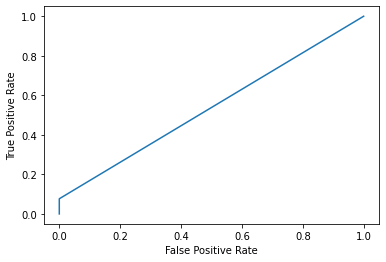

In [ ]:
fpr, tpr, _ = roc_curve(Y_val, y_score, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_val, y_score) * 100 )) 

ROC_AUC:  53.83


## Neural Network

##### Create Dataset

In [ ]:
batch_size = 32
img_height = 128
img_width = 128

In [ ]:
folder = "/content/gdrive/MyDrive/ML_workspace/Dataset/immagini-3/immagini-3"
X_CAA, y_CAA = load_images_from_folder(folder,"rgb", img_width, img_height)

Muskmelon
Peach
Kiwi
Pear
Plum
Persimmon
Apple


In [ ]:
X_train_, X_val_, Y_train_, Y_val_, X_outlier, Y_outlier, X_test,  Y_test = create_anomaly_detection_dataset(X_CAA, y_CAA)

In [ ]:
#substitute the value -1 for the anomalies with the value 0, this will be useful 
#later for the evalutation of the standard metrics

Y_train_ = np.where(Y_train_ == -1, 0, Y_train_) 
Y_val_ = np.where(Y_val_ == -1, 0, Y_val_)
Y_test_ = np.where(Y_test == -1, 0, Y_test) 

### AutoEncoder

####Dense AutoEncoder

##### Prepare the dataset

In [ ]:
# normalizae the imagesDense
X_train_NN = []
for i in range(len(X_train)):
  X_train_NN.append(X_train[i]/255)

X_val_NN = []
for i in range(len(X_val)):
  X_val_NN.append(X_val[i]/255)

X_test_NN = []
for i in range(len(X_test)):
  X_test_NN.append(X_test[i]/255)

#convert the type
X_train_NN = np.array(X_train_NN)
X_val_NN= np.array(X_val_NN)
X_test_NN= np.array(X_test_NN)

In [ ]:
X_train_NN = X_train_NN.reshape((len(X_train_NN), np.prod(X_train_NN.shape[1:])))
X_val_NN = X_val_NN.reshape((len(X_val_NN), np.prod(X_val_NN.shape[1:])))
X_test_NN = X_test_NN.reshape((len(X_test_NN), np.prod(X_test_NN.shape[1:])))

##### Test 1

###### Build the model

In [ ]:
class AnomalyDetector(tf.keras.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    #define the encoder
    self.encoder = tf.keras.Sequential([
        keras.layers.Input(shape=img_height* img_width),  
        layers.Dense(3000, activation="relu"),
        layers.Dense(1500, activation="relu"),
        layers.Dense(500, activation="relu"),


    ])
    #define the decoder
    self.decoder = tf.keras.Sequential([
      layers.Dense(500, activation="relu"),
      layers.Dense(1500, activation="relu"),
      layers.Dense(3000, activation="relu"),
      layers.Dense(img_height* img_width, activation="sigmoid")
    ])

  def call(self, x):
    encoder = self.encoder(x)
    decoder = self.decoder(encoder)
    return decoder

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

###### Train the model

In [ ]:
#check if the model exist
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
MODEL_NAME = "AUTOENCODER_1"
rerun = False

file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.hist'
model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'

exists = os.path.isfile(file_)
if exists and not rerun:
  with open(file_,'rb') as hist_file:
    history_dict = pickle.load(hist_file)
    autoencoder.fit(X_train_NN,X_train_NN, epochs = 1, batch_size=64)
    autoencoder.load_weights(model_file)
else:
  history = autoencoder.fit(X_train_NN,X_train_NN, epochs = 50, batch_size=64)
  history_dict = history.history
  with open(file_,'wb') as hist_file:
      pickle.dump(history_dict, hist_file)
      autoencoder.save_weights(model_file)
  

63/63 [==============================] - 3s 33ms/step - loss: 0.1877


###### Loss Valutation and plotting

Compute the threshold for the training images, this threshold will be used to classify the image

In [ ]:
reconstructions_train = autoencoder.predict(X_train_NN)
train_loss = [tf.keras.losses.mae(reconstructions_train[i].flatten(), X_train_NN[i].flatten()) for i in range(X_train_NN.shape[0])]

#compute the threshold, will be used to classify the images either oulier od inlier
threshold = np.mean(train_loss) + np.std(train_loss)


Distribution of the validation data, with inlier and outlier

In [ ]:
#reconstructions of the validation data, and validation loss
reconstructions_val = autoencoder.predict(X_val_NN)
val_loss = [tf.keras.losses.mae(reconstructions_val[i].flatten(), X_val_NN[i].flatten()) for i in range(X_val_NN.shape[0])]


Plotting od the different distribution

Text(0, 0.5, 'No of examples')

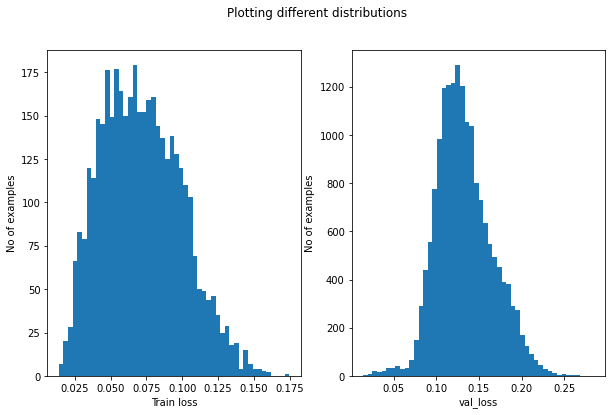

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,6)
fig.suptitle("Plotting different distributions")
ax1.hist(train_loss, bins=50)
ax1.set_xlabel("Train loss")
ax1.set_ylabel("No of examples")

ax2.hist(val_loss, bins=50)
ax2.set_xlabel("val_loss")
ax2.set_ylabel("No of examples")


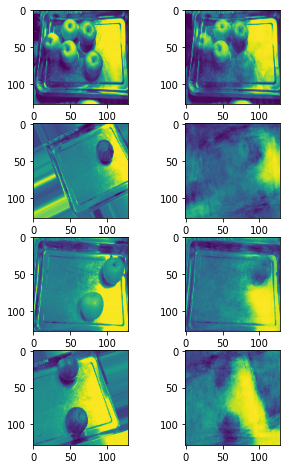

In [ ]:
#see how the inlier are rebuilded
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(X_train_NN[i])
    imgs.append(reconstructions_train[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img.reshape(img_height, img_width))
plt.show()

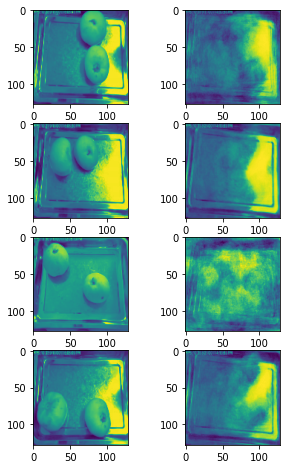

In [ ]:
#take 4 outlier to plot
X_plot = X_val_NN[y_val == 0][0:5]
reconstructions_plot = autoencoder.predict(X_plot)


#see how the outlier are rebuilded
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(X_plot[i])
    imgs.append(reconstructions_plot[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img.reshape(img_height, img_width))
plt.show()

###### ROC-AUC Validation set (X_val)

Since the y_score should rapresent the probability to be in the posotive class, and since the positive class in my case are the inlier. 
In my case the losses rapresent the probability to stay in the anomaly, since grater value means you are an anomaly, lower value means you are a normal value.

In [ ]:
y_score = np.ones(len(val_loss)) - val_loss

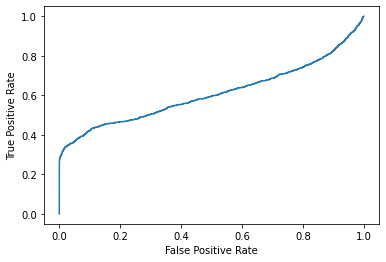

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(y_val, y_score) * 100 )) 


ROC_AUC:  60.81


###### ROC-AUC complete dataset (X_test)

In [ ]:
reconstructions_train = autoencoder.predict(X_train_NN)
train_loss = [tf.keras.losses.mae(reconstructions_train[i].flatten(), X_train_NN[i].flatten()) for i in range(X_train_NN.shape[0])]

#compute the threshold, will be used to classify the images either oulier od inlier
threshold = np.mean(train_loss) + np.std(train_loss)

In [ ]:
y_score = np.ones(len(val_loss)) - val_loss

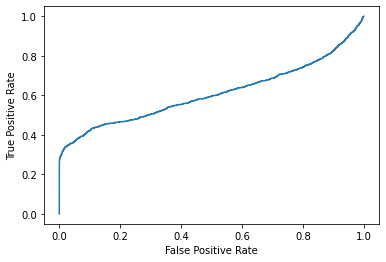

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(y_val, y_score) * 100 )) 


ROC_AUC:  60.81


#### Convolutional AutoEncoder

These approaches does not work very well because the network reconstruct both outlier and outlier too weel, so the reconstruction error is the same for both the images and also the y_score is the same for both category. The network became too good in rebuild the normal data that is able to rebuild also the anomalies.

This problem came from the fact that the images are barely the same, each fruit has the same form and the only difference is the form, so is likely that the features for the anomalies are the same also for the inlier. So the things in common are much more than the differences between the images.

We just need a network that is not able to rebuild the anomaly as good as it rebuild the inlier.

##### Test 1

###### Build the model

In [ ]:
class CNN_anomaly_detector(tf.keras.Model):
  def __init__(self):
    super(CNN_anomaly_detector, self).__init__()
    #define encoder
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D(pool_size=(2,2), padding='same'), 

        layers.Conv2D(8,(3, 3),activation='relu',  padding='same'),
        layers.MaxPooling2D(pool_size=(2,2), padding='same'),

        layers.Conv2D(3,(3, 3),activation='relu',  padding='same'),
        layers.MaxPooling2D(pool_size=(2,2), padding='same')
        
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2D(3,(3, 3),activation='relu',  padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2D(8,(3, 3),activation='relu',  padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2D(16,(3, 3),activation='relu',  padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2D(3,(3, 3), activation='sigmoid', padding='same')
        
    ])


  def call(self, x):
    encoder = self.encoder(x)
    decoder = self.decoder(encoder)
    return decoder

cnn_autoencoder = CNN_anomaly_detector()

In [ ]:
#cnn_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
cnn_autoencoder.compile(optimizer='adam', loss='mae')

###### Train the model

In [ ]:
#check if the model exist
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
MODEL_NAME = "AUTOENCODER_2"
rerun = False

file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.hist'
model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'

exists = os.path.isfile(file_)
if exists and not rerun:
  with open(file_,'rb') as hist_file:
    history_dict = pickle.load(hist_file)
    #run the model just for one epoch
    cnn_autoencoder.fit(X_train_,X_train_, epochs = 1, batch_size=32)
    cnn_autoencoder.load_weights(model_file)
else:
  history = cnn_autoencoder.fit(X_train_,X_train_, epochs = 100, batch_size=32)
  history_dict = history.history
  with open(file_,'wb') as hist_file:
      pickle.dump(history_dict, hist_file)
      cnn_autoencoder.save_weights(model_file)
  

126/126 [==============================] - 15s 24ms/step - loss: 0.1526


###### Model Valutation

Threshold computation

In [ ]:
reconstructions = cnn_autoencoder.predict(X_train_)

train_loss = [tf.keras.losses.mae(reconstructions[i].flatten(), X_train_[i].flatten()) for i in range(X_train_.shape[0])]

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

**Plotting Images**

In [ ]:
#see how the outlier are rebuilded
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(X_train_[i])
    imgs.append(reconstructions[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

###### Standard Measures

In [ ]:
outlier = -1
inlier = 1

X_val_test = X_val_[:5000]
Y_val_test = Y_val_[:5000]

reconstructions = cnn_autoencoder.predict(X_val_test)
preds = []
losses = []
for i in range(len(X_val_test)):
  loss = tf.keras.losses.mae(reconstructions[i].flatten(), X_val_test[i].flatten())
  losses.append(loss)
  preds.append(np.where(loss > threshold, outlier, inlier)) 


I take as anomaly only the value grather than the threshold because are the values whose error is farest from the normal loss of the normal data.

In [ ]:
print_stats(preds, Y_val_test)

###### AUC

Since the y_score should rapresent the probability to be in the posotive class, and since the positive class in my case are the inlier. 
In my case the losses rapresent the probability to stay in the anomaly, since grater value means you are an anomaly, lower value means you are a normal value.

In [ ]:
y_score = np.ones(len(losses)) - losses

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_val_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_val_test, y_score) * 100 )) 


##### Test 2

###### Build The Model

In [ ]:
class CNN_anomaly_detector(tf.keras.Model):
  def __init__(self):
    super(CNN_anomaly_detector, self).__init__()
    #define encoder
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(img_height, img_width, 3)),
        layers.Conv2D(8,(3, 3),activation='relu',  padding='same'),
        layers.Conv2D(3,(3, 3),activation='relu',  padding='same'),

        
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2D(3,(3, 3),activation='relu',  padding='same'),
        layers.Conv2D(8,(3, 3),activation='relu',  padding='same'),
        layers.Conv2D(16, (3, 3), padding='same',activation='relu'),
        layers.Conv2D(3,(3, 3), activation='sigmoid', padding='same')
        
    ])


  def call(self, x):
    encoder = self.encoder(x)
    decoder = self.decoder(encoder)
    return decoder

cnn_autoencoder = CNN_anomaly_detector()

In [ ]:
#cnn_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
cnn_autoencoder.compile(optimizer='adam', loss='mae')

###### Train the model

In [ ]:
#check if the model exist
DIR = "/content/gdrive/MyDrive/ML_workspace/models_images"
MODEL_NAME = "AUTOENCODER_3"
rerun = True

file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.hist'
model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'

exists = os.path.isfile(file_)
if exists and not rerun:
  with open(file_,'rb') as hist_file:
    history_dict = pickle.load(hist_file)
    #run the model just for one epoch
    cnn_autoencoder.fit(X_train_,X_train_, epochs = 1, batch_size=32)
    cnn_autoencoder.load_weights(model_file)
else:
  history = cnn_autoencoder.fit(X_train_,X_train_, epochs = 100, batch_size=64)
  history_dict = history.history
  with open(file_,'wb') as hist_file:
      pickle.dump(history_dict, hist_file)
      cnn_autoencoder.save_weights(model_file)
  

###### Model Valutation

In [ ]:
reconstructions = cnn_autoencoder.predict(X_train_)

train_loss = [tf.keras.losses.mae(reconstructions[i].flatten(), X_train_[i].flatten()) for i in range(X_train_.shape[0])]

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
outlier = X_outlier[:5000]
np.random.shuffle(outlier)
reconstructions_anomaly = cnn_autoencoder.predict(outlier)

train_loss = [tf.keras.losses.mae(reconstructions_anomaly[i].flatten(), outlier[i].flatten()) for i in range(outlier.shape[0])]

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

###### Plotting Recostructed images

In [ ]:
#see how the outlier are rebuilded
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(X_train_[i])
    imgs.append(reconstructions[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:
#see how the outlier are rebuilded
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(outlier[i])
    imgs.append(reconstructions_anomaly[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()


In [ ]:
outlier = -1
inlier = 1

X_val_test = X_val_[:5000]
Y_val_test = Y_val_[:5000]

reconstructions = cnn_autoencoder.predict(X_val_test)
preds = []
losses = []
for i in range(len(X_val_test)):
  loss = tf.keras.losses.mae(reconstructions[i].flatten(), X_val_test[i].flatten())
  losses.append(loss)
  preds.append(np.where(loss > threshold, outlier, inlier))


###### Standard Metrics

In [ ]:
print_stats(preds, Y_val_test)

###### AUC

In [ ]:
y_score = np.ones(len(losses)) - losses 

In [ ]:
losses = np.array(losses)
losses_norm = sklearn.preprocessing.normalize(losses.reshape(-1, 1), axis=0)
losses_norm

In [ ]:
fpr, tpr, _ = metrics.roc_curve(Y_val_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_val_test, y_score) * 100 )) 
